# 线性回归

问题描述：
房价预测
1. 假设影响房价的关键因素是卧室个数、卫生间个数、居住面积，记作x_1、x_2、x_3
2. 假设房价是3个关键因素的加权和 y = w_1 * x_1 + w_2 * x_2 + w_3 * x_3 + b


拓展：
- n维输入：x = [x_1, x_2, ..., x_n]^T
- 线性模型：n维权重和标量偏差 w = [w_1, w_2, ..., w_n]^T, b
- 输出：y = <w, x> + b

线性模型可以看作单层神经网络：输入层x-输出层y

损失函数：
- 平方损失：loss = (y_hat - y)^2 / 2

线性模型有显示解

# 优化方法

梯度下降
- 任意选择一个初始值 w_0
- 迭代参数 t = 1, 2, 3...
- 超参数-学习率：η
- w_t = w_{t-1} - η * ▽loss(w_{t-1})

小批量随机梯度下降
- 在整个训练集上计算梯度太贵
- 随机采样 b 个样本来近似损失
- 超参数-批量大小：b

# 实现线性回归

import

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

构建数据集

使用 w = [2, -3.4]^T, b = 4.2, 噪声e 构造一个数据集

y = X * w + b + e

features: tensor([1.6612, 1.2998]) 
label: tensor([3.1009])


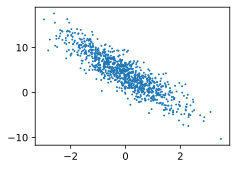

In [3]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 均值为0，方差为1，num_examples行，len(w)列
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

real_w = torch.tensor([2, -3.4])
real_b = 4.2
num_examples = 1000

features, labels = synthetic_data(real_w, real_b, num_examples)

print('features:', features[0], '\nlabel:', labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

获取样本

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 打乱顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]  # 持续生成小批量

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0209,  0.5067],
        [ 2.1288,  0.9834],
        [ 0.7347,  0.1296],
        [-1.3601, -0.5098],
        [ 0.7658, -1.2390],
        [ 1.4854,  1.0275],
        [-0.3876, -0.8991],
        [ 0.3793,  0.6782],
        [-0.7124, -1.3045],
        [ 0.9137, -1.2443]]) 
 tensor([[ 2.5350],
        [ 5.1088],
        [ 5.2160],
        [ 3.2059],
        [ 9.9436],
        [ 3.6710],
        [ 6.4561],
        [ 2.6560],
        [ 7.2152],
        [10.2552]])


初始化模型

In [20]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
    """
    模型：线性回归
    参数：
    X: 特征features
    w: 权重
    b: 偏差
    """
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """
    损失函数：均方损失
    参数：
    y_hat: 预测值
    y: 真实值
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    """
    优化算法：小批量随机梯度下降
    参数：
    params: 参数列表
    lr: 学习率
    batch_size: 批量大小
    """
    with torch.no_grad():  # 更新时禁用梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # l的形状为(batch_size, 1)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.036019
epoch 2, loss 0.000130
epoch 3, loss 0.000049


训练结果

In [23]:
print(f'w: {w}\nreal_w: {real_w}')
print(f'w的估计误差: {real_w - w.reshape(real_w.shape)}')
print(f'b: {b}\nreal_b: {real_b}')
print(f'b的估计误差: {real_b - b}')

w: tensor([[ 1.9995],
        [-3.3992]], requires_grad=True)
real_w: tensor([ 2.0000, -3.4000])
w的估计误差: tensor([ 0.0005, -0.0008], grad_fn=<SubBackward0>)
b: tensor([4.1992], requires_grad=True)
real_b: 4.2
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


# 简洁实现

数据生成与获取

In [6]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

real_w = torch.tensor([2, -3.4])
real_b = 4.2
features, labels = d2l.synthetic_data(real_w, real_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):
    """数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

初始化模型

In [16]:
from torch import nn

# 单层放在Sequential里，该层的输入输出维度为2和1
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)  # 初始化w
net[0].bias.data.fill_(0)  # 初始化b

# 损失函数：均方误差
loss = nn.MSELoss()

# 优化算法：小批量随机梯度下降
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

训练

In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000232
epoch 2, loss 0.000101
epoch 3, loss 0.000101


训练结果

In [18]:
w = net[0].weight.data
b = net[0].bias.data

print(f'w: {w}\nreal_w: {real_w}')
print(f'w的估计误差: {real_w - w.reshape(real_w.shape)}')
print(f'b: {b}\nreal_b: {real_b}')
print(f'b的估计误差: {real_b - b}')

w: tensor([[ 1.9998, -3.3996]])
real_w: tensor([ 2.0000, -3.4000])
w的估计误差: tensor([ 0.0002, -0.0004])
b: tensor([4.1996])
real_b: 4.2
b的估计误差: tensor([0.0004])
